### Feature Engineering

#### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

#### Load the EDA & Preprocessing notebook

In [3]:
df2 = pd.read_parquet("/home/data/processed/PreProcessing.parquet")

#### Time Based Calender features

In [4]:
df2['hour'] = df2['Timestamp'].dt.hour
df2['dayofweek'] = df2['Timestamp'].dt.dayofweek
df2['is_weekend'] = df2['dayofweek'] >= 5
df2['month'] = df2['Timestamp'].dt.month
df2['day'] = df2['Timestamp'].dt.day

#### Cyclical Time Features for Time Series Data

In [5]:
# Cyclical encoding for hour
df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24).round(4)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24).round(4)

# Same for day of week
df2['dayofweek_sin'] = np.sin(2 * np.pi * df2['dayofweek'] / 7).round(4)
df2['dayofweek_cos'] = np.cos(2 * np.pi * df2['dayofweek'] / 7).round(4)

# Optional month encoding if relevant
df2['month_sin'] = np.sin(2 * np.pi * (df2['month'] - 1) / 12).round(4)
df2['month_cos'] = np.cos(2 * np.pi * (df2['month'] - 1) / 12).round(4)

In [6]:
df2.head()

,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],...,dayofweek,is_weekend,month,day,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,1376314846,4,11703.99824,10912.027692,93.233333,67108864.0,6.129274e+06,0.133333,15981.600000,0.000000,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
1,1376315146,4,11703.99824,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,0.000000,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
2,1376315446,4,11703.99824,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,535.666667,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
3,1376315746,4,11703.99824,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,349.666667,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
4,1376316046,4,11703.99824,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,0.000000,...,0,False,8,12,-0.5000,-0.8660,0.0,1.0,-0.5,-0.866


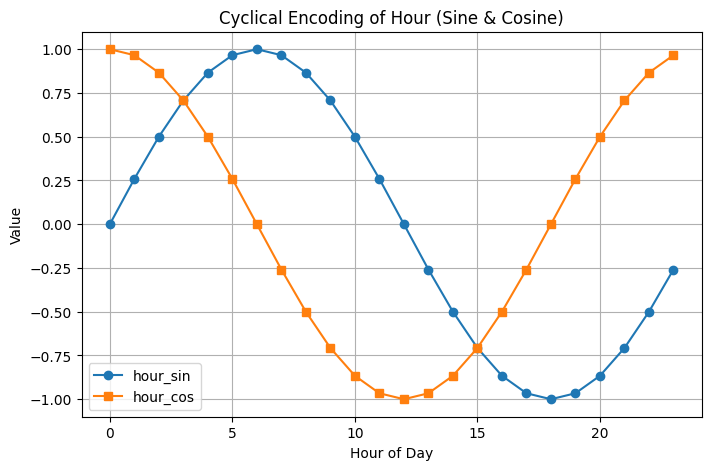

In [7]:
import matplotlib.pyplot as plt

# Example: Plot cyclical encoding for one day (0 to 23 hours)
hours = np.arange(0, 24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

plt.figure(figsize=(8, 5))
plt.plot(hours, hour_sin, label='hour_sin', marker='o')
plt.plot(hours, hour_cos, label='hour_cos', marker='s')
plt.title("Cyclical Encoding of Hour (Sine & Cosine)")
plt.xlabel("Hour of Day")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

#### Compute the CPU & Memory usage

In [8]:
df2['cpu_utilization_ratio'] = (df2['CPU usage [MHZ]'] / df2['CPU capacity provisioned [MHZ]']).round(4)
df2['memory_utilization_ratio'] = (df2['Memory usage [KB]'] / df2['Memory capacity provisioned [KB]']).round(4)

# Optional: Convert to percentage view for easy debugging (not for modeling)
df2['cpu_util_percent'] = (df2['cpu_utilization_ratio'] * 100).round(2)
df2['memory_util_percent'] = (df2['memory_utilization_ratio'] * 100).round(2)

#### Lag Features Trend Detection of CPU & Memory Features

In [9]:
# Resource Utilization Change Features (Trend Detection)

df2['cpu_util_prev'] = df2.groupby('VM')['cpu_utilization_ratio'].shift(1)
df2['cpu_util_diff'] = df2['cpu_utilization_ratio'] - df2['cpu_util_prev']

df2['memory_util_prev'] = df2.groupby('VM')['memory_utilization_ratio'].shift(1)
df2['memory_util_diff'] = df2['memory_utilization_ratio'] - df2['memory_util_prev']

#### Compute the Disk Usage Ratio, Rolling stats

In [10]:
# Total Disk Throughput
df2['disk_total_throughput'] = (
    df2['Disk read throughput [KB/s]'] + df2['Disk write throughput [KB/s]']
)

# Rolling Average and Std for Disk (window size = 5)
df2['disk_rolling_mean'] = (
    df2.groupby('VM')['disk_total_throughput']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df2['disk_rolling_std'] = (
    df2.groupby('VM')['disk_total_throughput']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)

#### Compute the Network Throughput, Rolling stats

In [11]:
# Total Network Throughput
df2['network_total_throughput'] = (
    df2['Network received throughput [KB/s]'] + df2['Network transmitted throughput [KB/s]']
)

# Rolling Average and Std for Network (window size = 5)
df2['network_rolling_mean'] = (
    df2.groupby('VM')['network_total_throughput']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df2['network_rolling_std'] = (
    df2.groupby('VM')['network_total_throughput']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)

####  Lag Features Trend Detection of Disk & Network Features

In [12]:
# -------------------- Disk Features --------------------
if 'Disk read throughput [KB/s]' in df2.columns:
    df2['disk_read_prev'] = df2.groupby('VM')['Disk read throughput [KB/s]'].shift(1)
    df2['disk_read_diff'] = df2['Disk read throughput [KB/s]'] - df2['disk_read_prev']

if 'Disk write throughput [KB/s]' in df2.columns:
    df2['disk_write_prev'] = df2.groupby('VM')['Disk write throughput [KB/s]'].shift(1)
    df2['disk_write_diff'] = df2['Disk write throughput [KB/s]'] - df2['disk_write_prev']

# -------------------- Network Features --------------------
df2['network_received_prev'] = df2.groupby('VM')['Network received throughput [KB/s]'].shift(1)
df2['network_received_diff'] = df2['Network received throughput [KB/s]'] - df2['network_received_prev']

df2['network_transmitted_prev'] = df2.groupby('VM')['Network transmitted throughput [KB/s]'].shift(1)
df2['network_transmitted_diff'] = df2['Network transmitted throughput [KB/s]'] - df2['network_transmitted_prev']

# Total Network Throughput Change per VM
df2['network_total_prev'] = df2.groupby('VM')['network_total_throughput'].shift(1)
df2['network_total_diff'] = df2['network_total_throughput'] - df2['network_total_prev']

In [13]:
print(df2['cpu_utilization_ratio'].isnull().sum())  # count of NaNs
print(np.isinf(df2['cpu_utilization_ratio']).sum()) # count of infinite values

1133235
7987


#### Resource Utilization Behavior

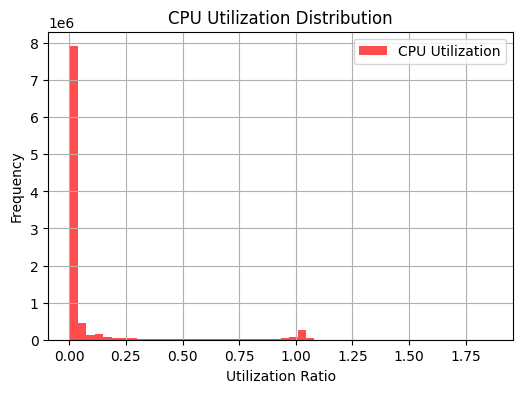

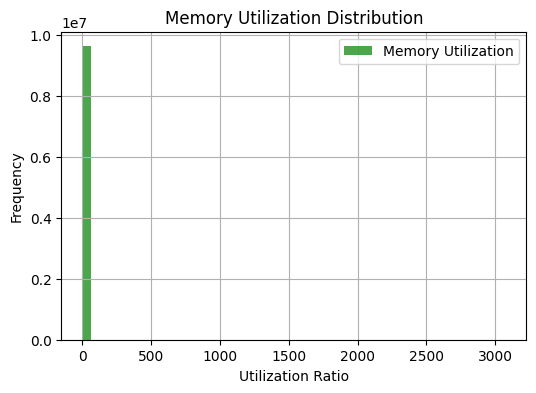

In [14]:
# Remove NaNs and infinite values
clean_cpu = df2['cpu_utilization_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
clean_mem = df2['memory_utilization_ratio'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 4))
plt.hist(clean_cpu, bins=50, alpha=0.7, color='red', label='CPU Utilization')
plt.title("CPU Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(clean_mem, bins=50, alpha=0.7, color='green', label='Memory Utilization')
plt.title("Memory Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

In [15]:
#### 🔹 Optional – Cluster VMs by Behavior

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

# features_for_cluster = vm_summary.drop(columns=['VM'])  # Only metrics
# scaled = StandardScaler().fit_transform(features_for_cluster)

# kmeans = KMeans(n_clusters=4, random_state=42)
# vm_summary['cluster'] = kmeans.fit_predict(scaled)

# # Check cluster sizes
# print(vm_summary['cluster'].value_counts())

# # Sample plot
# sns.pairplot(vm_summary, hue='cluster', vars=['CPU usage [%]_mean', 'Memory usage [KB]_mean'])
# plt.suptitle("Clustered VM Behavior", y=1.02)
# plt.show()

In [17]:
print(df2.columns.tolist())

['Timestamp [s]', 'CPU cores', 'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]', 'VM', 'Timestamp', 'time_idx', 'time_diff', 'hour', 'dayofweek', 'is_weekend', 'month', 'day', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'cpu_utilization_ratio', 'memory_utilization_ratio', 'cpu_util_percent', 'memory_util_percent', 'cpu_util_prev', 'cpu_util_diff', 'memory_util_prev', 'memory_util_diff', 'disk_total_throughput', 'disk_rolling_mean', 'disk_rolling_std', 'network_total_throughput', 'network_rolling_mean', 'network_rolling_std', 'disk_read_prev', 'disk_read_diff', 'disk_write_prev', 'disk_write_diff', 'network_received_prev', 'network_received_diff', 'network_transmitted_prev', 'network_transmitted_diff', 'network_total_prev', 'network

#### Save the cleaned DataFrame to a Parquet file

In [ ]:
df2.to_parquet("/home/data/processed/FeatureEng.parquet", index=False)

In [ ]:
df2.shape()